# Métodos Wrapper y Embedded

Este notebook, by [Felipe Alonso Atienza](www.linkedin.com/in/felipe-alonso-atienza)

En este notebook se revisarán los conceptos de:

1. Métodos *wrapper*
2. Métodos *embedded*

Primero cargamos librerías y funciones necesarias


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

# 1. Métodos Wrapper

Estos métodos utilizan un algoritmo de machine learning como caja negra para rankear distintos subconjuntos de variables de acuerdo a su capacidad predictiva. Normalmente se usan en mediante procedimientos hacia delante/detrás en combinación con validación cruzada.

### *The wrong and right way to do cross-validation*

Este ejemplo ha sido inspirado en *7.10.2 The Wrong and Right Way to Do Cross-validation* del libro
"The Elements of Statistical Learning". Hastie, Tibshirani, Friedman

/Users/Felipe/.conda/envs/python_36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Error rate (%): 3.572


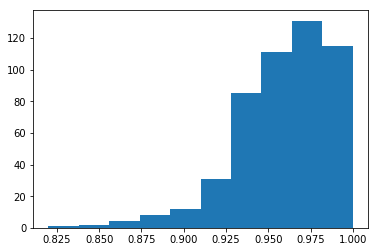

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_selection import f_classif


# This is the WRONG way

np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors are random variables!!
    
    # Note here, the ranking and selection is performed outside the CV loop
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:,selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(N, n_folds=5, shuffle = True)
    score_i = []
    
    for train, validation in kf:
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

Error rate (%): 52.664


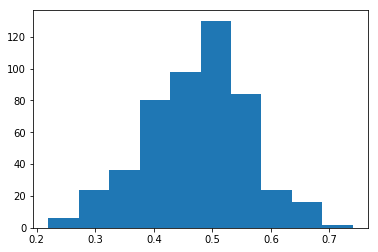

In [3]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(N, n_folds=5, shuffle = True)
    score_i = []
    
    for train, validation in kf:
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train,:], y[train])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:,selected]
        
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

# 2. Métodos embedded

Vamos a trabajar directamente sobre la base de datos  de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), así que lo primero es cargar los datos

In [30]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years'] = 2019 - house_data['yr_built']
house_data = house_data.drop(['yr_built','sqm_above'],axis=1)
house_data = house_data[house_data.sqm_living <= 600]


#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
#house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
#house_data['lat_plus_long']    = house_data['lat']*house_data['long']

house_data.head()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,sqm_basement,yr_renovated,zip_code,lat,long,sqm_living15,sqm_lot15,years
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,0.000000,0,98178,47.5112,-122.257,124.490074,524.902176,64
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,37.161216,1991,98125,47.7210,-122.319,157.006138,709.686323,68
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,0.000000,0,98028,47.7379,-122.233,252.696269,748.984308,86
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,84.541766,0,98136,47.5208,-122.393,126.348134,464.515200,54
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,0.000000,0,98074,47.6168,-122.045,167.225472,697.051509,32


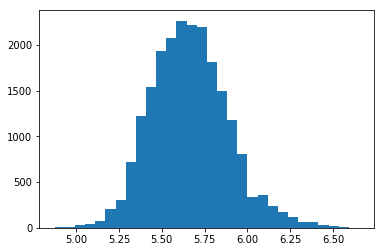

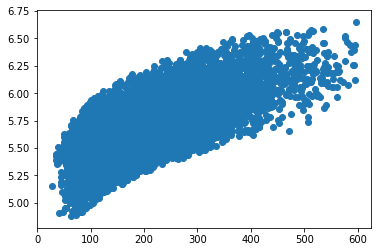

In [52]:
plt.hist(np.log10(house_data.price),bins=30)
plt.show()

plt.scatter(house_data.sqm_living,np.log10(house_data.price))
plt.show()

In [48]:
house_data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21568.0,534959.642433,341357.402350,75000.000000,321000.000000,450000.000000,641000.000000,4.489000e+06
bedrooms,21568.0,3.367350,0.926683,0.000000,3.000000,3.000000,4.000000,3.300000e+01
bathrooms,21568.0,2.108436,0.756119,0.000000,1.500000,2.250000,2.500000,7.500000e+00
sqm_living,21568.0,192.148022,81.843245,26.941882,131.922317,177.444806,235.973722,5.973665e+02
sqm_lot,21568.0,1389.661587,3791.006065,48.309581,468.231322,706.620522,988.256088,1.534163e+05
floors,21568.0,1.493231,0.539595,1.000000,1.000000,1.500000,2.000000,3.500000e+00
waterfront,21568.0,0.007233,0.084741,0.000000,0.000000,0.000000,0.000000,1.000000e+00
view,21568.0,0.230759,0.758944,0.000000,0.000000,0.000000,0.000000,4.000000e+00
condition,21568.0,3.409774,0.651011,1.000000,3.000000,3.000000,4.000000,5.000000e+00
grade,21568.0,7.648322,1.160938,1.000000,7.000000,7.000000,8.000000,1.300000e+01


In [53]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
# probar
y = np.log10(data[:,0:1])     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [54]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#--- ESTO NO SE PUEDE HACER!!
X_mal = preprocessing.StandardScaler().fit_transform(X)
#---

# Dividimos los datos en entrenamiento y test (75 training, 25 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (16176, 17)
Datos test:  (5392, 17)


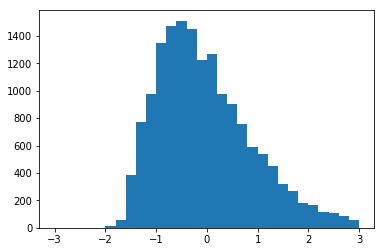

In [55]:
plt.hist(XtrainScaled[:,2],range = [-3,3],bins=30)
plt.show()

En este caso, utilizamos la capacidad de Lasso para seleccionar variable

best mean cross-validation score: -0.012
best parameters: {'alpha': 6.9519279617756056e-05}


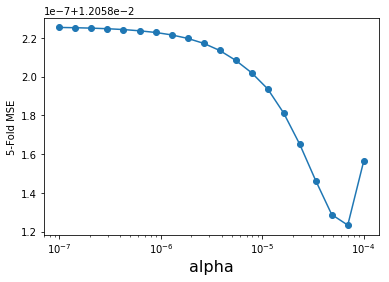

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# primera iteración
#alpha_vector = np.logspace(-1,10,50)
# segunda iteración
#alpha_vector = np.logspace(0,2,20)

# Nueva búsqueda para variable y en escala logarítmica
alpha_vector = np.logspace(-7,-4,20)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

$\hat{y} = w_0 + w_1x_{s,1} + w_2x_{s,2} + \ldots$

In [65]:
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))



w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)


MSE Modelo Lasso (train): 0.0126
MSE Modelo Lasso (test) : 0.0122
RMSE Modelo Lasso (train): 0.112
RMSE Modelo Lasso (test) : 0.11
bedrooms 0.0
bathrooms 0.0143294540742
sqm_living 0.0612324167138
sqm_lot 0.0
floors 0.00529996392999
waterfront 0.00889461165549
view 0.0193272606412
condition 0.012060749954
grade 0.0772148987056
sqm_basement 0.0
yr_renovated 0.0031628491622
zip_code -0.0
lat 0.0773425425158
long -0.0
sqm_living15 0.0218223677464
sqm_lot15 0.0
years 0.0290853185449


Como puede apreciarse, con este algoritmo hemos conseguido "desactivar" algunas variables (*sqm_lot*, *sqm_basement*, *long*, *bedrooms_squared*, *bed_bath_rooms*), lo que mejora la interpretabilidad del modelo a costa de aumentar ligeramente el error en test con respecto al método Ridge.

No obstante, siguen apareciendo algunas incoherencias con respecto al valor de los coeficientes, como por ejemplo el asociado a la variable *bedrooms* que tiene valor negativo. 

Vamos a aumentar el parámetro de regularización y observar los resultados obtenidos:

In [ ]:
alpha_optimo = 2e4
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

Hemos aumentado el error, pero a cambio:

1. Tenemos un modelo más sencillo (menos variables al haber muchos coeficientes nulos) y por tanto, menos susceptible a sufrir overfitting
2. Mejoramos la interpretabilidad del modelo, las variables supervivientes (con coeficiente distintos de cero) parecen concordar con nuestra intuición sobre problema a resolver

Y una vez llegados a este punto, ¿qué podemos hacer? El error de entrenamiento/validación y test es similar, pero todavía es muy alto, así que: 

1. Se podrían definir nuevas variables que nos ayuden a mejorar el error de predicción (mse)
2. Jugar con el parámetro de regularización, para mantener el compromiso entre sencillez/interpretabilidad del modelo y error de predicción (MSE).

